# Inferential statistics II - Bootstrapping

## Introduction

In the previous frequentist mini-projects, you did frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th-Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold for the particular case you're working on, and what you want to do has a known theoretical distribution (for example the mean of a sampling distribution that we looked at in the previous mini-project.)

In this mini-project, you'll use the same medical charge data you used in the frequentist inference mini-project, but this time you'll make inferences about the population using bootstrapping (ie. simulating repeated re-runs of an experiment.) If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

While these exercises do not strictly depend on these concepts, we encourage you to complete the previous mini-projects before starting this one so that you can approach this assignment with a good understanding of frequentist concepts like:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete mini-project, it's important that you first complete the bootstrap resources listed in this subunit, as they contain valuable information about how to calculate bootstrap replicates of summary statistics. Having an basic understanding of what confidence intervals and p-values are will also be helpful (we touch on them in this mini-project, but please speak to your mentor or conduct individual research if you'd like to learn more.) 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you'll now use bootstrap inference to verify your calculations and check that you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

In [4]:
np.random.seed(47)
N_rep = 10000
allcharges = med_charges['charges'].array

def create_rep(data, func):
    replicate = np.random.choice(data, len(data))
    return func(replicate)

def draw_bs_reps(data, func, size = 1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = create_rep(data, func)
    return bs_replicates
bs_allcharges = draw_bs_reps(allcharges, np.mean, size=N_rep)

In [5]:
#Find the 95% confidence interval
con_inf = np.percentile(bs_allcharges, [2.5,97.5])
con_inf

array([12624.86211913, 13918.00929997])

If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember, in the previous mini-projects, we saw that there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__ Null Hypothesis: The standard deviation for the insured and the non-insured are the same. Alternative hypothesis is that the standard deviation is higher for those without insurance

In [6]:
#extracting the data of those with/without insurance claim
insured = (med_charges['charges'].loc[med_charges['insuranceclaim']==1]).array
noninsured = (med_charges['charges'].loc[med_charges['insuranceclaim']==0]).array

In [7]:
#Create a permutation function for 2 datasets
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)

    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

#Create a function to generate replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates
#Create a function to generate difference in standard deviation
def diff_of_std(data_1, data_2):
    # The difference of means of data_1, data_2: diff
    diff = np.std(data_1) - np.std(data_2)

    return diff

In [8]:
#Create replicates for standard deviation differences
std_reps = draw_perm_reps(insured, noninsured, diff_of_std, size=10000)
std_interval = np.percentile(std_reps, [2.5, 97.5])
std_interval

array([-1224.80955756,  1248.52022784])

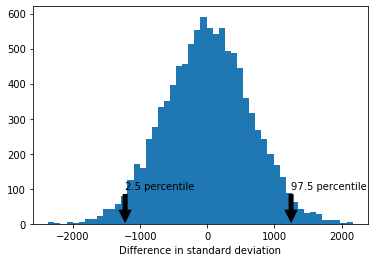

In [9]:
plt.hist(std_reps, bins=50)
a1 = np.percentile(std_reps, 2.5)
a2 = np.percentile(std_reps, 97.5)
plt.annotate('2.5 percentile', xy=(a1, 0), xytext=(a1, 100), arrowprops={"facecolor": 'black', "shrink": 0.05}
)
plt.annotate('97.5 percentile', xy=(a2, 0), xytext=(a2, 100), arrowprops={"facecolor": 'black', "shrink": 0.05}
)
plt.xlabel('Difference in standard deviation')
plt.show()

As we can see, the value 0 is within the confidence interval so the hypothesis test is statistically significant.

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type I error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__ Null Hypothesis: The difference between the means of the insured and the noninsured is 0. Alternative hypothesis: The means is higher for the insured

In [10]:
#Finding the observed means difference
diff_obs = np.mean(insured) - np.mean(noninsured)
diff_obs

7602.506384231368

In [11]:
#Finding the combined means
means_concat = np.mean(np.concatenate([insured, noninsured]))

In [12]:
#shift the both datasets to have the same mean
shifted_insured = insured - np.mean(insured) + means_concat
shifted_noninsured = noninsured - np.mean(noninsured) + means_concat
#created replicates of the means of the shifted datasets
bs_insured_reps = draw_bs_reps(shifted_insured, np.mean, size=10000)
bs_noninsured_reps = draw_bs_reps(shifted_noninsured, np.mean, size=10000)
#get replicates of the difference in means
bs_reps_means = bs_insured_reps - bs_noninsured_reps

In [19]:
#Compute the probability of getting a value as big as the observed means when the null hypothesis is true
p = np.sum(bs_reps_means>=diff_obs)/10000
p

0.0

As we can see from the above, p value is very small and as close as 0. That means given that the null hypothesis of equal means being true, it is very unlikely there is means difference at least as big as the one we observed. As a result, we can reject the null hypothesis in this case.

__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__ The reason we have 2 lines is because the difference can go both way (insured-non-insured) and (non-insured - insured)

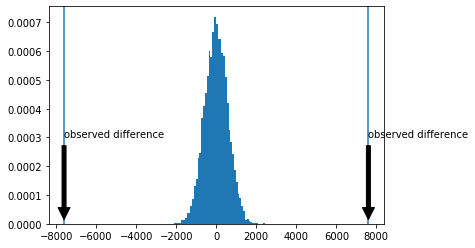

In [33]:
plt.hist(bs_reps_means, bins=50, density = True)
plt.axvline(x = diff_obs)
plt.axvline(x = -diff_obs)
plt.annotate('observed difference', xy=(diff_obs, 0), xytext=(diff_obs, 0.0003), arrowprops={"facecolor": 'black', "shrink": 0.05}
)
plt.annotate('observed difference', xy=(-diff_obs, 0), xytext=(-diff_obs, 0.0003), arrowprops={"facecolor": 'black', "shrink": 0.05}
)
plt.show()

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ With 10000 replicates as above, there was 0 mean with value as high as the observed difference. Perhaps if I try to increase the size, we might spot an outlier eventually.

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ I would use the t-test for the same standard variance since we can see from the question above that there is a high chance the standards deviation of these two datasets are the same.

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__ I would carry out a two-sided tests as above as well. The null hypothesis: the mean click-through rates are the same for A and B. Alternative: The new algorithm B generate more click-through rate. Consequences of rejecting the null when it is in fact true is that we might lose money carrying out new algorithm without it actually making any improvement.

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have:
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.